In [1]:
import os

# Set JAVA_HOME to the path where your Java is installed
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"

from pyspark.sql import SparkSession

# Create a SparkSession
spark = SparkSession.builder \
    .appName("CSV Import") \
    .getOrCreate()

# Read your CSV file
df = spark.read.csv("./data/data.csv", header=True, inferSchema=True)
df.show()

spark.stop()


25/04/03 00:51:06 WARN Utils: Your hostname, oem resolves to a loopback address: 127.0.1.1; using 172.16.1.202 instead (on interface wlp3s0)
25/04/03 00:51:06 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


25/04/03 00:51:06 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|   InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|12/1/2010 8:26|     2.55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|12/1/2010 8:26|     2.75|     17850|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|    22752|SET 7 BABUSHKA NE...|       2|12/1/2010 8:26|     7.65|     17850|United Kingdom|
|   536365|    21730|GLASS STAR FROSTE...|       6|12/1/2010 8:26|     4.

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_timestamp, max as spark_max, datediff, lit, count, sum as spark_sum
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans

# Create a SparkSession
spark = SparkSession.builder \
    .appName("CSV Import with Legacy Time Parser") \
    .config("spark.sql.legacy.timeParserPolicy", "LEGACY") \
    .getOrCreate()

# Read the CSV file; adjust the path if necessary
# Assume the CSV has at least these columns: CustomerID, InvoiceDate, InvoiceNo, Amount
df = spark.read.csv("./data/data.csv", header=True, inferSchema=True)

# Convert InvoiceDate to a date type (adjust the format string as needed)
df = df.withColumn("InvoiceDate", to_timestamp(col("InvoiceDate"), "M/d/yyyy H:mm"))

# Create a new column 'TotalAmount' by multiplying 'Quantity' and 'UnitPrice'
df = df.withColumn("TotalAmount", col("Quantity") * col("UnitPrice"))

# Determine the reference date as the maximum InvoiceDate in the data
max_date = df.select(spark_max("InvoiceDate").alias("max_date")).collect()[0]["max_date"]

# Aggregate data to compute RFM metrics for each customer
# - Recency: days since last purchase (difference between reference date and last purchase date)
# - Frequency: total number of invoices (or transactions)
# - Monetary: total spend (sum of Amount)
rfm_df = df.groupBy("CustomerID").agg(
    datediff(lit(max_date), spark_max("InvoiceDate")).alias("Recency"),
    count("InvoiceNo").alias("Frequency"),
    spark_sum("TotalAmount").alias("Monetary")
)

print("RFM Metrics:")
rfm_df.show(10)

# Assemble the RFM metrics into a feature vector
assembler = VectorAssembler(
    inputCols=["Recency", "Frequency", "Monetary"],
    outputCol="features_unscaled"
)
rfm_features = assembler.transform(rfm_df)

# Standardize features for better clustering performance (optional but recommended)
scaler = StandardScaler(
    inputCol="features_unscaled", 
    outputCol="features",
    withStd=True, 
    withMean=True
)
scaler_model = scaler.fit(rfm_features)
rfm_features = scaler_model.transform(rfm_features)

# Train a KMeans model on the features; here we choose k=4 clusters (adjust as needed)
k = 4
kmeans = KMeans(featuresCol="features", predictionCol="cluster", k=k, seed=42)
model = kmeans.fit(rfm_features)

# Add cluster assignments to the DataFrame
rfm_clustered = model.transform(rfm_features)

print("RFM Clustering Results:")
rfm_clustered.select("CustomerID", "Recency", "Frequency", "Monetary", "cluster").show(10)

# Stop the Spark session when done
spark.stop()


RFM Metrics:


+----------+-------+---------+------------------+
|CustomerID|Recency|Frequency|          Monetary|
+----------+-------+---------+------------------+
|     17420|     50|       30| 598.8299999999999|
|     16861|     59|        8|            151.65|
|     16503|    106|       86|           1421.43|
|     15727|     16|      302| 5178.959999999998|
|     17389|      0|      224|31300.079999999994|
|     15447|    330|        9|            155.17|
|     14450|    180|       40|            483.25|
|     13623|     30|       86|            672.44|
|     13285|     23|      187|2709.1199999999994|
|     16339|    284|       20|109.95000000000002|
+----------+-------+---------+------------------+
only showing top 10 rows



RFM Clustering Results:


+----------+-------+---------+------------------+-------+
|CustomerID|Recency|Frequency|          Monetary|cluster|
+----------+-------+---------+------------------+-------+
|     17420|     50|       30| 598.8299999999999|      0|
|     16861|     59|        8|            151.65|      0|
|     16503|    106|       86|           1421.43|      3|
|     15727|     16|      302| 5178.959999999998|      0|
|     17389|      0|      224|31300.079999999994|      0|
|     15447|    330|        9|            155.17|      2|
|     14450|    180|       40|            483.25|      3|
|     13623|     30|       86|            672.44|      0|
|     13285|     23|      187|2709.1199999999994|      0|
|     16339|    284|       20|109.95000000000002|      2|
+----------+-------+---------+------------------+-------+
only showing top 10 rows



RFM Metrics:


+----------+-------+---------+------------------+
|CustomerID|Recency|Frequency|          Monetary|
+----------+-------+---------+------------------+
|     17420|     50|       30| 598.8299999999999|
|     16861|     59|        8|            151.65|
|     16503|    106|       86|           1421.43|
|     15727|     16|      302| 5178.959999999998|
|     17389|      0|      224|31300.079999999994|
|     15447|    330|        9|            155.17|
|     14450|    180|       40|            483.25|
|     13623|     30|       86|            672.44|
|     13285|     23|      187|2709.1199999999994|
|     16339|    284|       20|109.95000000000002|
+----------+-------+---------+------------------+
only showing top 10 rows



For k = 2, WSSSE = 4298.120738618633


For k = 3, WSSSE = 1158.630742387911


For k = 4, WSSSE = 730.7611004003616


For k = 5, WSSSE = 559.9524196982053


For k = 6, WSSSE = 385.6158328040657


For k = 7, WSSSE = 300.482614845768


For k = 8, WSSSE = 212.58064350552038


For k = 9, WSSSE = 191.96648429784582


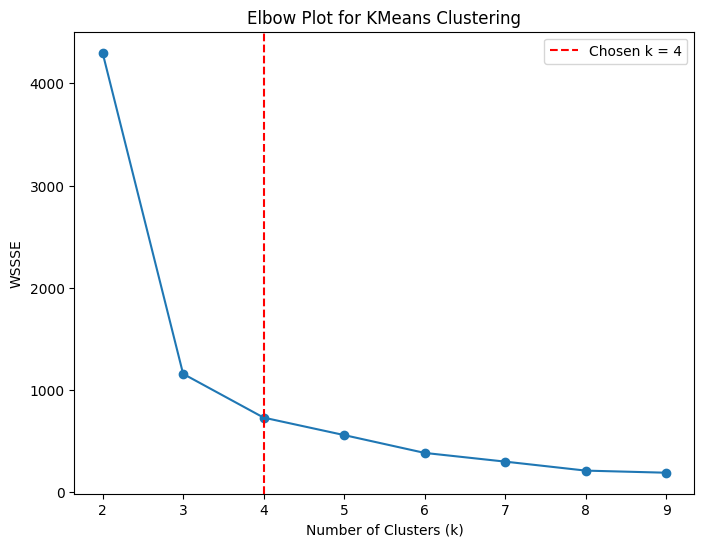

RFM Clustering Results:


+----------+-------+---------+------------------+-------+
|CustomerID|Recency|Frequency|          Monetary|cluster|
+----------+-------+---------+------------------+-------+
|     17420|     50|       30| 598.8299999999999|      0|
|     16861|     59|        8|            151.65|      0|
|     16503|    106|       86|           1421.43|      3|
|     15727|     16|      302| 5178.959999999998|      0|
|     17389|      0|      224|31300.079999999994|      0|
|     15447|    330|        9|            155.17|      2|
|     14450|    180|       40|            483.25|      3|
|     13623|     30|       86|            672.44|      0|
|     13285|     23|      187|2709.1199999999994|      0|
|     16339|    284|       20|109.95000000000002|      2|
+----------+-------+---------+------------------+-------+
only showing top 10 rows



In [3]:
import os
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_timestamp, max as spark_max, datediff, lit, count, sum as spark_sum
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans

# Create folders if they don't exist
os.makedirs("./models", exist_ok=True)
os.makedirs("./tables", exist_ok=True)

# Create a SparkSession with legacy time parser enabled
spark = SparkSession.builder \
    .appName("CSV Import with Data Cleaning and KMeans") \
    .config("spark.sql.legacy.timeParserPolicy", "LEGACY") \
    .getOrCreate()

# Read the CSV file; adjust the path if necessary
df = spark.read.csv("./data/data.csv", header=True, inferSchema=True)

# Data Cleaning:
# 1. Exclude rows where Quantity is 0
# 2. Use only rows where Country is 'United Kingdom'
df = df.filter((col("Quantity") != 0) & (col("Country") == "United Kingdom"))

# Convert InvoiceDate to a timestamp; adjust format as needed (e.g. "M/d/yyyy H:mm")
df = df.withColumn("InvoiceDate", to_timestamp(col("InvoiceDate"), "M/d/yyyy H:mm"))

# Create a new column 'TotalAmount' by multiplying 'Quantity' and 'UnitPrice'
df = df.withColumn("TotalAmount", col("Quantity") * col("UnitPrice"))

# Determine the reference date as the maximum InvoiceDate in the data
max_date = df.select(spark_max("InvoiceDate").alias("max_date")).collect()[0]["max_date"]

# Aggregate data to compute RFM metrics for each customer:
# - Recency: days since the last purchase (difference between reference date and most recent purchase)
# - Frequency: total number of invoices (or transactions)
# - Monetary: total spend (sum of TotalAmount)
rfm_df = df.groupBy("CustomerID").agg(
    datediff(lit(max_date), spark_max("InvoiceDate")).alias("Recency"),
    count("InvoiceNo").alias("Frequency"),
    spark_sum("TotalAmount").alias("Monetary")
)

print("RFM Metrics:")
rfm_df.show(10)

# Assemble the RFM metrics into a feature vector
assembler = VectorAssembler(
    inputCols=["Recency", "Frequency", "Monetary"],
    outputCol="features_unscaled"
)
rfm_features = assembler.transform(rfm_df)

# Standardize features for better clustering performance
scaler = StandardScaler(
    inputCol="features_unscaled", 
    outputCol="features",
    withStd=True, 
    withMean=True
)
scaler_model = scaler.fit(rfm_features)
rfm_features = scaler_model.transform(rfm_features)

# Determine the optimal number of clusters using an elbow plot
wssse = []
ks = list(range(2, 10))  # Testing k from 2 to 9
for k in ks:
    kmeans_temp = KMeans(featuresCol="features", predictionCol="cluster", k=k, seed=42)
    model_temp = kmeans_temp.fit(rfm_features)
    cost = model_temp.summary.trainingCost
    wssse.append(cost)
    print(f"For k = {k}, WSSSE = {cost}")

# Plot the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(ks, wssse, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WSSSE")
plt.title("Elbow Plot for KMeans Clustering")
plt.axvline(x=4, color="red", linestyle="--", label="Chosen k = 4")
plt.legend()
plt.savefig("./tables/elbow_plot.png")
plt.show()

# Train a KMeans model using k=4 clusters
k = 4
kmeans = KMeans(featuresCol="features", predictionCol="cluster", k=k, seed=42)
model = kmeans.fit(rfm_features)

# Add cluster assignments to the DataFrame
rfm_clustered = model.transform(rfm_features)

print("RFM Clustering Results:")
rfm_clustered.select("CustomerID", "Recency", "Frequency", "Monetary", "cluster").show(10)

# Save the KMeans model to the "./models" folder
model.save("./models/kmeans_model")

# Save the clustered RFM DataFrame as a Parquet file in the "./tables" folder
rfm_clustered.write.mode("overwrite").parquet("./tables/rfm_clustered.parquet")

# Stop the Spark session
spark.stop()
